# Hits, misses and false alarms
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 27-06-2023<br>


**Introduction**:<br>
This notebooks computes the hits (true positives, $TP$), misses (false negatives, $FN$) and false alarms (false positives, $FP$) for all the selected reporting points and the complete study period.

The input data are the data sets of exceedance over threshold both for the reanalsysis ("observed") and the forecast.

The confusion matrix (hits, misses, false alarms) is computed for all the possible combinations of three criteria: model combination method (named _approach_), persistence, and probability threshold. The values of persisntece and probability thresholds for which the confusion matrix will be evaluated are defined by the user.

The result is a new set of NetCDF files (one for station) that contains matrixes of hits, misses and false alarms for every combination of the criteria.

**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [21]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
import yaml

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from compute import *
from seasonal import disaggregate_by_season
from convert import reshape_DataArray, dict2da
from plot.results import plot_DataArray
from plot.maps import create_cmap, map_events
os.chdir(path_root)

## 1 Configuration

In [2]:
with open("../conf/config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### 1.1 Reporting points

In [3]:
# area threshold
area_threshold = cfg.get('reporting_points', {}).get('area', 500)

# fixed notification criteria for the optimization process
area_optimization = cfg.get('skill', {}).get('area', 2000) 

# reporting points
path_stations = cfg.get('reporting_points', {}).get('output', '../results/reporting_points/')
file_stations = f'{path_stations}reporting_points_over_{area_threshold}km2.parquet'

### 1.2 Exceedance

In [4]:
# path where results from the preprocessing steps were saved
path_reanalysis = cfg.get('exceedance', {}).get('output', {}).get('reanalysis', f'../results/exceedance/reanalysis/')
path_forecast = cfg.get('exceedance', {}).get('output', {}).get('forecast', f'../results/exceedance/forecast/')

### 1.1 Hits

#### Notification criteria

##### Probability threshold

In [5]:
# probability thresholds
probability_range = cfg.get('hits', {}).get('criteria', {}).get('probability', [.05, .096, .05])
probability = np.arange(*probability_range).round(3)
probability = xr.DataArray(probability, dims=['probability'], coords={'probability': probability})

##### Persistence

A list of tuples with two values: the first value is the width of the window rolling sum, and the second value the minimum number of positives in that window so that a notification is raised.

In [6]:
persistence = cfg.get('hits', {}).get('criteria', {}).get('persistence', [(1, 1), (2, 2), (2, 3)])
persistence = {'/'.join([str(i) for i in pers]): pers for pers in persistence}

##### Computation of hits

In [7]:
# lead time ranges
leadtime = cfg.get('hits', {}).get('leadtime', None)

# parameters of the rolling window used to compute hits
window = cfg.get('hits', {}).get('window', 1)
center = cfg.get('hits', {}).get('center', True)

# dissagregate the analysis by seasons?
seasonality = cfg.get('hits', {}).get('seasonality', False)

# path where the dataset of hits, misses and false alarms will be saved
path_out = cfg.get('hits', {}).get('output', f'../results/hits/')
path_weights = f'{path_out}weighing/'
if seasonality:
    path_out += 'seasonal/'
for path in [path_weights, path_out]:
    if not os.path.exists(path):
        os.makedirs(path)

## 2 Data

### 2.1 Reporting points

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [8]:
# load table of fixed reporing points
stations = pd.read_parquet(file_stations)

### 2.2 Exceedance reanalysis

In [9]:
# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = xr.open_mfdataset(f'{path_reanalysis}*.nc', combine='nested', concat_dim='id')['exceedance']
rean_exc = rean_exc.sel(id=stations.index).compute()

if seasonality:
    rean_exc = disaggregate_by_season(rean_exc)

print(rean_exc.dims)
print(rean_exc.shape)

('id', 'datetime')
(2371, 2920)


### 2.3 Exceedance forecast

In [14]:
# load probability of exceeding the discharge threshold in the FORECAST data
fore_exc = xr.open_mfdataset(f'{path_forecast}*.nc', combine='nested', concat_dim='id')
fore_exc['id'] = fore_exc.id.astype(int)
fore_exc = fore_exc.sel(id=stations.index)

# reshape the DataArray of forecasted exceedance
fore_exc = xr.Dataset({label: reshape_DataArray(da, trim=True) for label, da in fore_exc.items()})
fore_exc = fore_exc.transpose('id', 'datetime', 'leadtime', 'model')

# extract starting and ending dates
if ('start' not in locals()) or ('end' not in locals()):
    start = pd.to_datetime(fore_exc.datetime.min().data)
    end = pd.to_datetime(fore_exc.datetime.max().data)

# recalculate the exceedance datasets to convert the 3 classes (>Q5, >0.95·Q5, <0.95·Q5) to only 2 (exceedance, non-exceedance)
rean_exc, fore_exc = recompute_exceedance(rean_exc.sel(datetime=slice(start, end)), fore_exc['high'], fore_exc['low'])

## 3 Analysis

### 3.1 Observed events
#### 3.1.1 Number of events

In [15]:
# find the onset of the events
onsets =  xr.concat((rean_exc.isel(datetime=0).astype(bool), rean_exc.diff('datetime')), dim='datetime') == 1
onsets = onsets.sel(datetime=slice(start, end))

# find the offset of the events
offsets = xr.concat((rean_exc.isel(datetime=0).astype(bool), rean_exc.diff('datetime')), dim='datetime') == -1
offsets = offsets.sel(datetime=slice(start, end))

# count number of events
stations['n_events_obs'] = onsets.sum('datetime').to_pandas()

print('No. stations with observed events:\t{0}'.format((stations.n_events_obs > 0).sum()))
print('No. observed events:\t\t\t{0}'.format(stations.n_events_obs.sum()))

if seasonality:
    # compute number of events per season
    rean_onsets4s = disaggregate_by_season(rean_onsets, dim='datetime')
    cols = ['n_events_obs_winter', 'n_events_obs_spring', 'n_events_obs_summer', 'n_events_obs_autumn']
    stations[cols] = rean_onsets4s.sum('datetime').to_pandas().transpose()

# export the stations table
stations.to_parquet(file_stations)

No. stations with observed events:	994
No. observed events:			1566


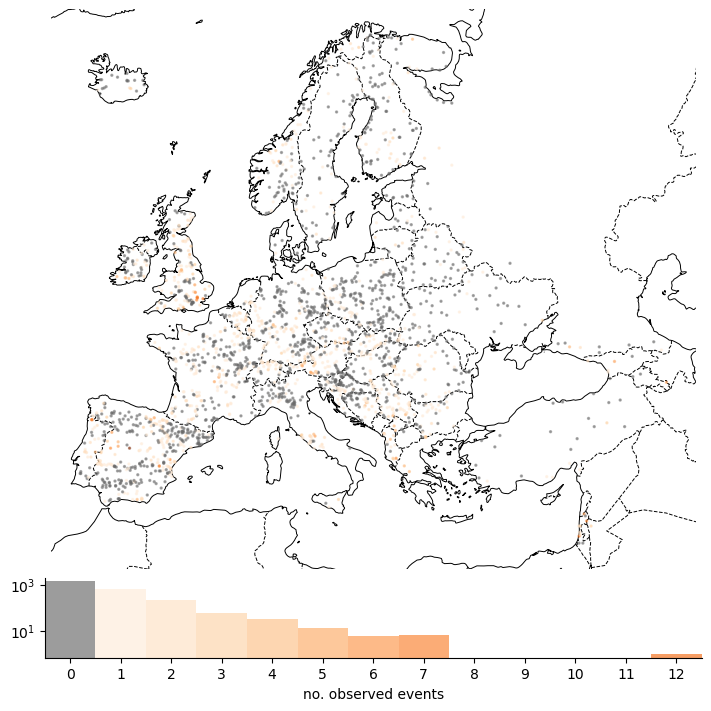

In [16]:
map_events(stations, 'n_events_obs', save=None, yscale='log')#=f'{path_out}/map_observed_events_{suffix}.jpg')

> ***Figure 2**. Number of observed flood events during the study period.*

The geographical distribution of events is not even. There is a higher proportion of stations with events in Central Europe, British Isles and the Mediterranean catchments than in Estearn and North-Eastern Europe. During the study period there were major events in the Rhine, Meuse and Ebro, which can be seen in the map.

The reporting points with more than 5 flood events during the study period were removed, since it is suspicious that the 5-year return period was exceeded so many times in only 2 years of study period.

#### 3.1.2 Duration of the events

In [17]:
# evaluate the duration (in hours) of each event
event_durations = {}
for stn in tqdm_notebook(onsets.id.data):
    if stations.loc[stn, 'n_events_obs'] == 0:
        continue
    # dates of the onsets and offsets of the events
    dates_onsets = onsets.sel(id=stn).where(onsets.sel(id=stn), drop=True).datetime.data
    dates_offsets = offsets.sel(id=stn).where(offsets.sel(id=stn), drop=True).datetime.data
    # corrections in case the amount of onsets and onsets don't match
    if len(dates_onsets) > len(dates_offsets):
        dates_offsets = np.append(dates_offsets, offsets.datetime[-1].data)
    elif len(dates_onsets) < len(dates_offsets):
        dates_onsets = np.append(onsets.datetime[0].data, dates_onsets)
    # correction in case the first onset is later that the first offset
    else:
        if dates_onsets[0] > dates_offsets[0]:
            print(stn)
            dates_onsets = np.append(onsets.datetime[0].data, dates_onsets)
            dates_offsets = np.append(dates_offsets, offsets.datetime[-1].data)
    # convert into hours
    durations = (dates_offsets - dates_onsets) / np.timedelta64(1, 'h')
    event_durations[stn] = durations

  0%|          | 0/2371 [00:00<?, ?it/s]

In [18]:
# convert dictionary of durations into a flattened array
durations_all, durations_opt = [], []
for stn, arr in event_durations.items():
    for d in arr:
        durations_all.append(d)
        if stations.loc[stn, 'area'] >= area_optimization:
            durations_opt.append(d)
durations_all = np.array(durations_all)
durations_opt = np.array(durations_opt)

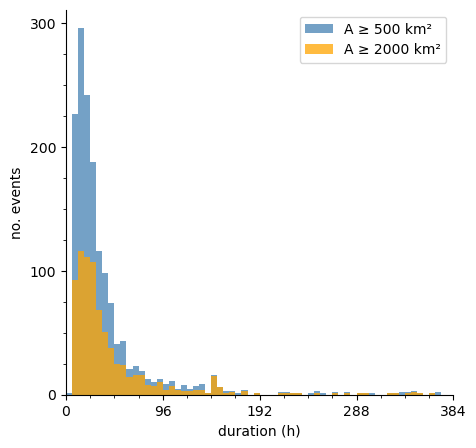

In [19]:
# plot distribution of event duration

xmin = 0
xmax = 16 * 24
bins = np.arange(xmin, xmax + 1, 6).astype(int)

fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(durations_all, ax=ax, bins=bins, color='steelblue', edgecolor=None, label=f'A ≥ {area_threshold} km²')
sns.histplot(durations_opt, ax=ax, bins=bins, color='orange', edgecolor=None, label=f'A ≥ {area_optimization} km²')
ax.set(xlabel='duration (h)', ylabel='no. events', xlim=(xmin, xmax));
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(96))
ax.xaxis.set_minor_locator(MultipleLocator(24))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.legend();

#plt.savefig(f'{path_out}duration_distribution.jpg', dpi=300, bbox_inches='tight')

### 3.2 Hits, misses and false alarms

In [24]:
path_netcdf = f'{path_out}window_{window}/'
if os.path.exists(path_netcdf) is False:
    os.makedirs(path_netcdf)

for stn in tqdm_notebook(stations.index):
    
    # check if the output file already exists
    file_out = f'{path_netcdf}{stn:>04}.nc'
    if os.path.exists(file_out):
        continue 
    
    # HITS, MISSES, FALSE ALARMS
    
    hits = {}
    for label, pers in persistence.items():
        
        # compute predicted events
        # pred = exceedance2events(total_exc, persistence=pers, min_leadtime='all')
        pred = exceedance2events(fore_exc.sel(id=stn), probability, persistence=pers, leadtime=leadtime)

        # disaggregate seasonaly
        if seasonality:
            pred = disaggregate_by_season(pred)

        # compute hits, misses and false alarms
        hits[label] = events2hits(rean_exc.sel(id=stn), pred, center=center, w=window)
    hits = dict2da(hits, dim='persistence')
            
    # convert to NaN lead times that can't be reached due to model limitations or persistence
    hits = limit_leadtime(hits)
    
    print(f'Exporting file {file_out}', end='\r')
    hits.to_netcdf(file_out)

    del pred, hits

  0%|          | 0/2371 [00:00<?, ?it/s]